In [17]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Hyperparameters
latent_dim = 100  # Dimension of the random noise input vector
img_shape = (28, 28, 1)  # Shape of generated images (28x28 grayscale)
batch_size = 64
epochs = 10000
sample_interval = 50  # Interval to save and display generated images

In [19]:
# 1. Build the Generator
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(256, activation="relu", input_dim=latent_dim),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(512, activation="relu"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(1024, activation="relu"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(np.prod(img_shape), activation="tanh"),
        layers.Reshape(img_shape)
    ])
    return model

# 2. Build the Discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=img_shape),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

# 3. Compile the GAN
def build_gan(generator, discriminator):
    discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    discriminator.trainable = False  # Freeze the discriminator when training the generator
    
    gan_input = layers.Input(shape=(latent_dim,))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss="binary_crossentropy", optimizer="adam")
    return gan

In [20]:
# 5. Generate and Save Sample Images
def sample_images(generator, epoch, grid_size=5):
    noise = np.random.normal(0, 1, (grid_size * grid_size, latent_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale images to [0, 1] for visualization

    fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5), sharex=True, sharey=True)
    count = 0
    for i in range(grid_size):
        for j in range(grid_size):
            axs[i, j].imshow(gen_imgs[count, :, :, 0], cmap="gray")
            axs[i, j].axis("off")
            count += 1
    plt.show()

In [21]:
# Train the GAN
def train_gan(generator, discriminator, gan, epochs, batch_size, sample_interval):
    # Load and preprocess the MNIST dataset
    (X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize images to [-1, 1]
    X_train = np.expand_dims(X_train, axis=-1)
    
    real = np.ones((batch_size, 1))  # Label for real images
    fake = np.zeros((batch_size, 1))  # Label for fake images
    
    for epoch in range(epochs):
        # Train the Discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generated_imgs = generator.predict(noise)
        
        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(generated_imgs, fake)
        
        # Handle d_loss as a list to prevent the formatting error
        if isinstance(d_loss_real, list) and isinstance(d_loss_fake, list):
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            d_loss_loss, d_loss_acc = d_loss[0], d_loss[1]
        else:
            d_loss_loss, d_loss_acc = 0.5 * (d_loss_real + d_loss_fake), 0  # Set accuracy to 0 if not available
        
        # Train the Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, real)  # We want the generated images to be classified as real
        
        if epoch % 10 == 0:
            print(f"epoch: {epoch}")

        # Display progress
        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss_loss}, acc.: {100*d_loss_acc}%] [G loss: {g_loss}]")
            sample_images(generator, epoch)


In [ ]:
# 6. Instantiate and Run the GAN
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

In [24]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')


Num GPUs Available:  0


[]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
epoch: 0
0 [D loss: 0.7699750661849976, acc.: 23.046875%] [G loss: [array(0.7653393, dtype=float32), array(0.7653393, dtype=float32), array(0.1796875, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


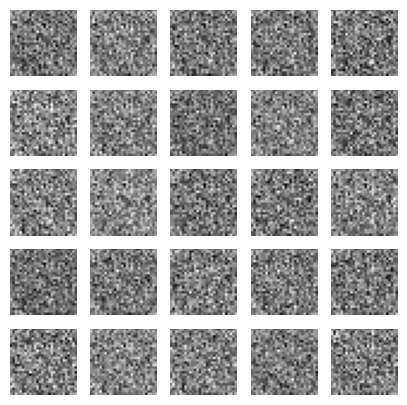

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
epoch: 10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
epoch: 20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2

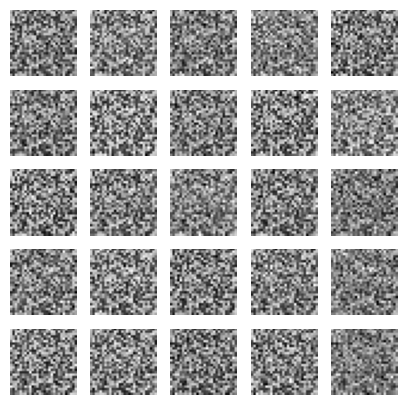

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
epoch: 60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
epoch: 70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0

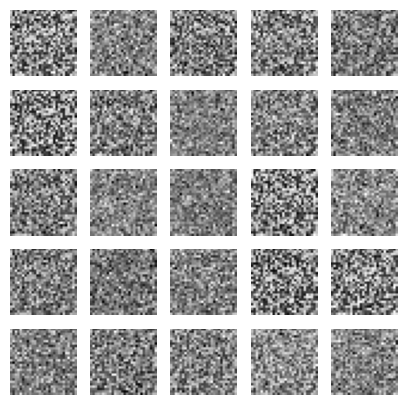

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
epoch: 110
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
epoch: 120
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

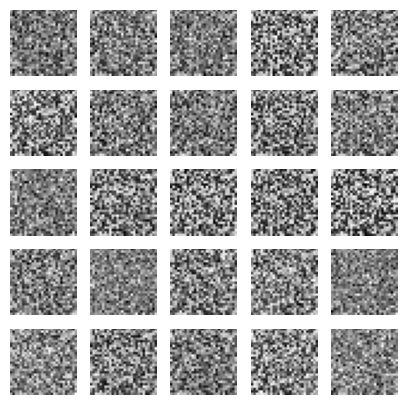

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
epoch: 160
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
epoch: 170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

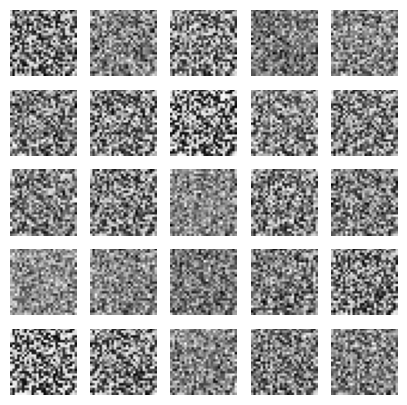

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
epoch: 210
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
epoch: 220
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

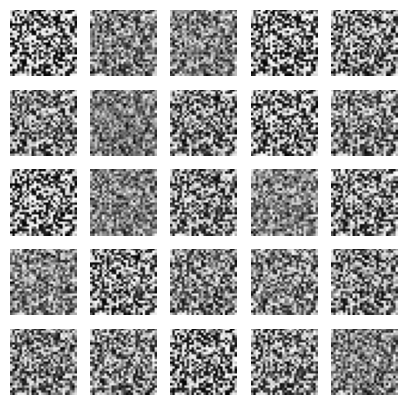

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
epoch: 260
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
epoch: 270
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

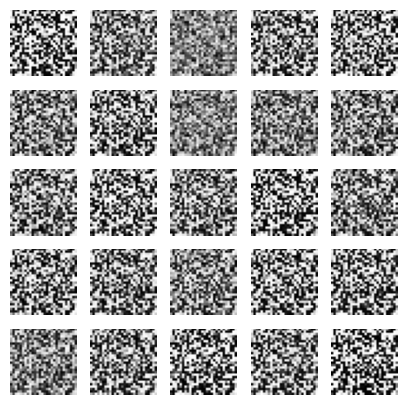

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
epoch: 310
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
epoch: 320
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

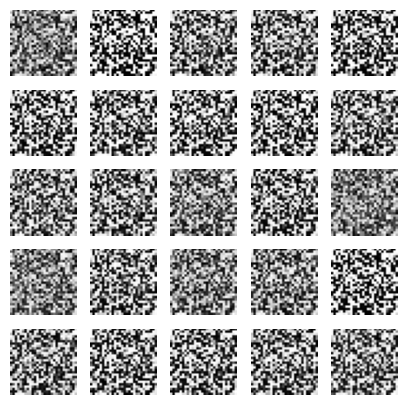

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
epoch: 360
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
epoch: 370
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

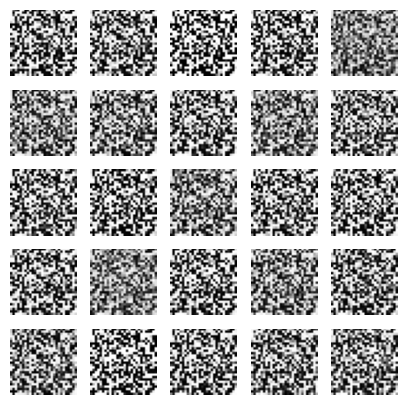

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
epoch: 410
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
epoch: 420
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

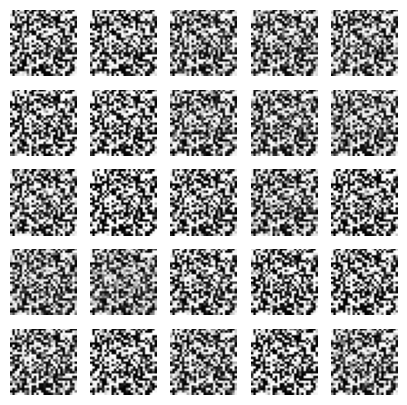

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
epoch: 460
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
epoch: 470
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

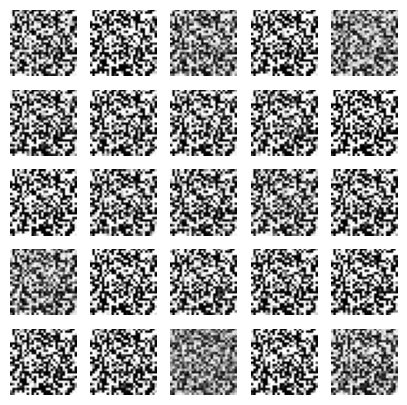

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
epoch: 510
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
epoch: 520
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

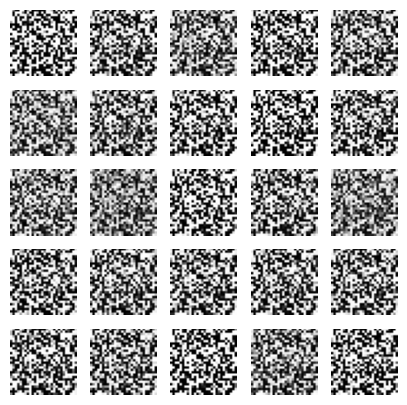

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
epoch: 560
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
epoch: 570
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0

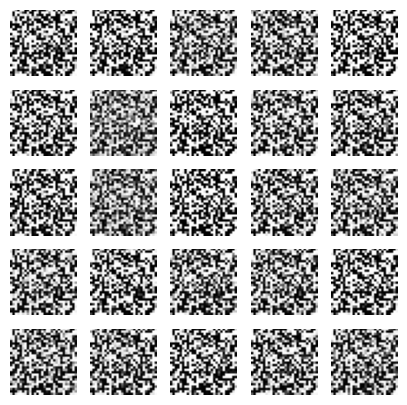

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
epoch: 610
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
epoch: 620
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

KeyboardInterrupt: 

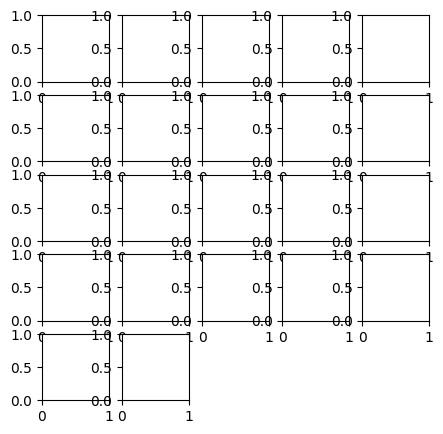

In [22]:
train_gan(generator, discriminator, gan, epochs, batch_size, sample_interval)